In [1]:
import numpy as np
from matplotlib import pyplot as plt
import ipywidgets as widgets
#Importing necessary libraries:
import oursin as urchin
import pandas as pd
urchin.setup(standalone=True)

(URN) connected to server
Login sent with ID: 885afa51, copy this ID into the renderer to connect.


(URN) disconnected from server
(URN) connected to server
Login sent with ID: 885afa51, copy this ID into the renderer to connect.


In [2]:
# binning raw data
def spikes_bin_data(spike_times_raw_data, spike_clusters_data):
    spike_times_raw_data = np.squeeze(spike_times_raw_data)
    spike_clusters_data = np.squeeze(spike_clusters_data)
    spike_times_sec = spike_times_raw_data / 3e4 # convert from 30khz samples to seconds
    # set up bin edges - 20 ms here
    bins_seconds = np.arange(np.min(spike_times_sec), np.max(spike_times_sec), 0.02)
    # make list of lists for spike times specific to each cluster
    spikes = [spike_times_sec[spike_clusters_data == cluster] for cluster in np.unique(spike_clusters_data)]
    # bin
    binned_spikes = []
    for cluster in spikes:
        counts, _ = np.histogram(cluster, bins_seconds)  
        binned_spikes.append(counts)
    binned_spikes = np.array(binned_spikes) # should be [#neurons, #bins]
    return binned_spikes

In [5]:
# if prev and post aren't exact intervals, flash warning and find nearest bin
def spikes_binned_event_average(binned_spikes, event_start, event_ids, bin_size_sec=0.02, window_start_sec = 0.1, window_end_sec = 0.5):
    bintime_prev = int(window_start_sec * 50)
    bintime_post = int(window_end_sec * 50 + 1)
    windowsize = bintime_prev + bintime_post
    bin_size = bin_size_sec * 1000

    # To bin: divide by 20, floor
    stim_binned = np.floor(event_start * 1000 / bin_size).astype(int)
    stim_binned = np.transpose(stim_binned)


    u_stim_ids = np.unique(event_ids)

    # Initialize final_avg matrix
    final_avg = np.empty((binned_spikes.shape[0], len(u_stim_ids), windowsize))

    for neuron_id in range(binned_spikes.shape[0]):

        for stim_id in u_stim_ids:
            stim_indices = np.where(event_ids[0] == stim_id)[0]

            neuron_stim_data = np.empty((len(stim_indices), windowsize))
            
            for i, stim_idx in enumerate(stim_indices):
                bin_id = int(stim_binned[0][stim_idx])
                selected_columns = binned_spikes[neuron_id, bin_id - bintime_prev: bin_id + bintime_post]
                neuron_stim_data[i,:] = selected_columns

            bin_average = np.mean(neuron_stim_data, axis=0)/bin_size_sec

            final_avg[neuron_id, int(stim_id) - 1, :] = bin_average
    final_avg = np.delete(final_avg, 88, axis=0) #DROPPING THE NEURON WITH THE HIGH BASELINE
    
    return final_avg


In [6]:
# processing data appropriately
from pathlib import Path
dpath = Path(r'../../data/')
st_samp = np.load(dpath / 'spike_times.npy')
sc = np.load(dpath / 'spike_clusters.npy')
binned_spikes = spikes_bin_data(st_samp,sc)
event_start = np.load("../../data/natImsOnTimes.npy")
event_ids = np.load("../../data/natImsIDs.npy") 
prepped_data = spikes_binned_event_average(binned_spikes,event_start,event_ids)

In [74]:
# pulling in location data
locations = pd.read_csv("../../data/allen_visual_behavior_firing_rate_modified.csv")
mask = (locations['dorsal_ventral_ccf_coordinate'] >= 0) & (locations['dorsal_ventral_ccf_coordinate'] <= 750)
locations = locations[mask]
locations = locations.iloc[::2]
locations = locations.iloc[:752]
# locations = locations.drop(88)
locations.reset_index(drop=True, inplace = True)

In [45]:
# locations['left_right_ccf_coordinate'] = locations['left_right_ccf_coordinate'].values + np.random.randn(len(locations),1) * 10
# locations['anterior_posterior_ccf_coordinate'] = locations['anterior_posterior_ccf_coordinate'].values + np.random.randn(len(locations),1) * 10
# locations['dorsal_ventral_ccf_coordinate'] = locations['dorsal_ventral_ccf_coordinate'].values + np.random.randn(len(locations),1) * 10

In [46]:
locations

,unit_id,left_right_ccf_coordinate,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,firing_rate,percentile_rank,color,size_scale
0,1049373132,7621.562854,7916.897949,504.181327,0.012007,0.030670,#f7f4fa,0.036627
1,1049374956,7636.560788,7929.403079,500.970335,2.592559,0.446954,#a88bc4,0.056381
2,1049374958,7617.859478,7912.435293,496.785151,1.682361,0.349738,#baa4d1,0.050978
3,1049374960,7622.210971,7917.846524,491.476849,2.084556,0.393849,#b299cb,0.053362
4,1049374962,7640.805960,7909.275231,491.077815,5.335466,0.656136,#8057aa,0.070026
...,...,...,...,...,...,...,...,...
747,1066210159,7603.230077,7920.675443,502.536395,3.734202,0.550329,#9471b7,0.062755
748,1066210161,7619.387572,7909.695010,500.638060,1.368314,0.313197,#c1add5,0.049084
749,1066210163,7609.677284,7921.043622,505.116592,2.061583,0.391445,#b399cb,0.053229
750,1066210165,7636.810873,7940.524375,495.227651,5.046041,0.639654,#845bac,0.068841


In [ ]:
locations["avg_spike"].idxmax()

In [79]:
locations

,unit_id,left_right_ccf_coordinate,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,firing_rate,percentile_rank,color,size_scale
0,1049373132,7620,7917,501,0.012007,0.030670,#72F246,0.036627
1,1049374956,7597,7929,739,2.592559,0.446954,#8957D7,0.056381
2,1049374958,7599,7928,718,1.682361,0.349738,#08AED4,0.050978
3,1049374960,7603,7926,678,2.084556,0.393849,#C6D2E8,0.053362
4,1049374962,7600,7928,708,5.335466,0.656136,#2A6624,0.070026
...,...,...,...,...,...,...,...,...
747,1066210159,7277,8082,714,3.734202,0.550329,#01E828,0.062755
748,1066210161,7277,8082,694,1.368314,0.313197,#116ED9,0.049084
749,1066210163,7278,8082,664,2.061583,0.391445,#07AEA3,0.053229
750,1066210165,7277,8082,674,5.046041,0.639654,#5FFD13,0.068841


In [80]:
# to pull out the proper averages:
locations["avg_spike"] = None
for neuron in range(prepped_data.shape[0]):
    neuron_data = prepped_data[neuron]  # Get the data for the current neuron
    average_value = neuron_data.mean()  # Calculate the average value for the neuron
    locations.iloc[neuron, 8] = average_value  # Assign the average value to the 8th column of locations DataFrame


In [81]:
max(locations["avg_spike"])

37.87096774193548

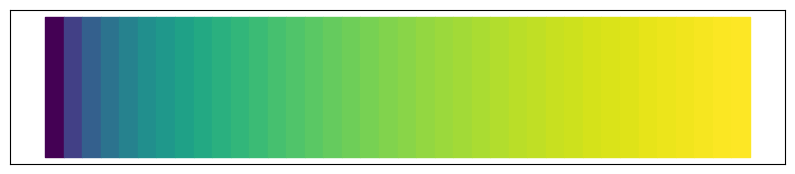

In [83]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the colormap
cmap = plt.cm.viridis  # You can choose any colormap you prefer

# Normalize values from 0 to 38 (logarithmic scale)
norm = mcolors.LogNorm(vmin=1, vmax=38)  # Set vmin to 1 to avoid log(0)

# Create a ScalarMappable object
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

# Interpolate colors
interpolated_colors = [sm.to_rgba(value) for value in range(1, 39)]  # Start from 1

# Plot the interpolated colors
plt.figure(figsize=(10, 2))
for i, color in enumerate(interpolated_colors):
    plt.fill_between([i, i+1], 0, 1, color=color)

plt.xticks([])  # Hide x-axis ticks
plt.yticks([])  # Hide y-axis ticks
plt.show()


In [84]:
import numpy as np

# Calculate the range of values in the size_scale column
# size_scale_max = locations['size_scale'].max()
# size_scale_min = locations['size_scale'].min()
# size_scale_range = size_scale_max - size_scale_min

# Iterate over each row in the DataFrame
for i in range(0,752):
    size_scale_value = locations.iloc[i, 8]  
    
    # Normalize the size_scale value to the range [0, 1]
    #normalized_value = (size_scale_value - size_scale_min) / size_scale_range
    
    # Ensure the normalized value is within the range [0, 1]
    #normalized_value = max(min(normalized_value, 1), 0)
    
    color_hex = mcolors.to_hex(interpolated_colors[int(size_scale_value)])
    
    locations.iloc[i,6] = color_hex


In [ ]:
specific_color_count = (locations['color'] == '#440154').sum()

In [40]:
colors[0]

'#7F5BA0'

In [85]:
locations

,unit_id,left_right_ccf_coordinate,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,firing_rate,percentile_rank,color,size_scale,avg_spike
0,1049373132,7620,7917,501,0.012007,0.030670,#440154,0.036627,0.045161
1,1049374956,7597,7929,739,2.592559,0.446954,#34608d,0.056381,2.72043
2,1049374958,7599,7928,718,1.682361,0.349738,#440154,0.050978,0.266667
3,1049374960,7603,7926,678,2.084556,0.393849,#440154,0.053362,0.112903
4,1049374962,7600,7928,708,5.335466,0.656136,#65cb5e,0.070026,15.733333
...,...,...,...,...,...,...,...,...,...
747,1066210159,7277,8082,714,3.734202,0.550329,#440154,0.062755,0.846237
748,1066210161,7277,8082,694,1.368314,0.313197,#440154,0.049084,0.222581
749,1066210163,7278,8082,664,2.061583,0.391445,#440154,0.053229,0.093548
750,1066210165,7277,8082,674,5.046041,0.639654,#440154,0.068841,0.188172


In [86]:
locations = locations.iloc[:,[1,2,3,6,8]]
locations.to_csv("../../data/li_location_colors_log.csv", index=False)

In [31]:
locations = pd.read_csv("../../data/li_location_colors_noise.csv")

In [18]:
def slope_viz_stimuli_per_neuron(t=-100, neuron_id = 0):
    
    # Plotting data:
    for i in range(0,prepped_data.shape[1]):
        y = prepped_data[neuron_id][i]
        x = np.arange(-100, 520, step=20)
        plt.plot(x,y)

    # Labels:
    plt.xlabel('Time from stimulus onset')
    plt.ylabel('Number of Spikes Per Second')
    plt.title(f'Neuron {neuron_id} Spiking Activity with Respect to Each Stimulus')

    #Accessories:
    plt.axvspan(0, 300, color='gray', alpha=0.3)
    plt.axvline(t, color='red', linestyle='--',)
    # Set y-axis limits
     # Calculate y-axis limits
    max_y = max([max(prepped_data[neuron_id][i]) for i in range(10)])  # Maximum y-value across all lines
    if max_y < 10:
        max_y = 10  # Set ymax to 10 if the default max is lower than 10
    plt.ylim(0, max_y)
   
    # plt.legend()
    plt.show()

In [19]:
#so new version would take just the neurons that are being changed in size, and the positions that are being changed
# [neuron][stim] stayes the same it's just time 3rd col time that's being manipulated as slider moves
def update_neuron_sizing(stim_id, t=-100):
    global neurons
    
    t = round((t+100)/20)
        
    size_list = []
    for i in range(prepped_data.shape[0]):
        size = round(prepped_data[i][stim_id][t]/100,1)
        # size = (round(row.percentile_rank,1))
        size_list.append(size)


    urchin.particles.set_sizes(neurons, size_list)

In [20]:
colors = list(locations["color"])

In [21]:
def slope_viz_neurons_per_stimuli(t = -100, stim_id = 0):
    # Plotting data:
    for i in range(0,prepped_data.shape[0]):
        y = prepped_data[i][stim_id]
        x = np.arange(-100, 520, step=20)
        plt.plot(x,y,color = colors[i])
    
    # Labels:
    plt.xlabel(f'Time from Stimulus {stim_id} display (20 ms bins)')
    plt.ylabel('Number of Spikes Per Second')
    plt.title(f'Neuron Spiking Activity with Respect to Stimulus ID {stim_id}')

    # Accessories:
    plt.axvspan(0, 300, color='gray', alpha=0.3)
    plt.axvline(t, color='red', linestyle='--',)
    plt.show()

    update_neuron_sizing(stim_id, t)
    

In [22]:
# time_slider = widgets.IntSlider(value=-100, min=-100, max=500, step=5, description='Time')
# time_slider.layout.width = '6.55in'
# time_slider.layout.margin = '0 -15px'

# neuron_dropdown = widgets.Dropdown(
#     options= range(0,prepped_data.shape[0]),
#     value=355,
#     description='Neuron ID:',
# )
# neuron_dropdown.layout.margin = "20px 20px"

# stimuli_dropdown = widgets.Dropdown(
#     options= range(0,prepped_data.shape[1]),
#     value=0,
#     description='Stimulus ID:',
# )
# stimuli_dropdown.layout.margin = "20px 20px"

# select_view_button = widgets.RadioButtons(
#     options=[("Stimulus View", "stim"), ("Neuron View", 'neuron')],
#     value = 'stim',
#     description='Select View:',
# )

In [23]:
# # Display interactive neuron graph:
# output = widgets.interactive_output(slope_viz_stimuli_per_neuron(prepped_data), {'t': time_slider, 'neuron_id': neuron_dropdown})

# # Display the widgets and the output
# display(widgets.VBox([neuron_dropdown,time_slider]))
# display(output)

In [24]:
# # Display interactive stimulus graph:
# output = widgets.interactive_output(slope_viz_neurons_per_stimuli(prepped_data), {'t': time_slider, 'stim_id': stimuli_dropdown})
# # Display the widgets and the output
# display(widgets.VBox([stimuli_dropdown,time_slider]))
# display(output)

In [25]:
def plot_appropriate_graph(view="stim"):
    time_slider = widgets.IntSlider(value=-100, min=-100, max=500, step=5, description='Time')
    time_slider.layout.width = '6.53in'
    time_slider.layout.margin = '0 -4px'
    
    if view == "stim":
        stimuli_dropdown = widgets.Dropdown(
            options= range(0,prepped_data.shape[1]),
            value=0,
            description='Stimulus ID:',
        )
        stimuli_dropdown.layout.margin = "20px 20px"
        output = widgets.interactive_output(slope_viz_neurons_per_stimuli, {'t': time_slider, 'stim_id': stimuli_dropdown})
        # Display the widgets and the output
        display(widgets.VBox([stimuli_dropdown,time_slider]))
        display(output)
    
    elif view == "neuron":
        neuron_dropdown = widgets.Dropdown(
            options= range(0,prepped_data.shape[0]),
            value=355,
            description='Neuron ID:',
        )
        neuron_dropdown.layout.margin = "20px 20px"

        # Link the function with the interact function
        output = widgets.interactive_output(slope_viz_stimuli_per_neuron, {'t': time_slider, 'neuron_id': neuron_dropdown})

        # Display the widgets and the output
        display(widgets.VBox([neuron_dropdown,time_slider]))
        display(output)


Incorporating Urchin portion below:

In [26]:
urchin.ccf25.load()

In [27]:
urchin.ccf25.grey.set_visibility(True)
urchin.ccf25.grey.set_material('transparent-unlit')
urchin.ccf25.grey.set_color([0,0,0])
urchin.ccf25.grey.set_alpha(0.1)

In [59]:
locations.to_csv('temp.csv')

In [71]:
locations = pd.read_csv('temp.csv')

In [72]:
#Setting positions (static):
positions_list = []

for i, row in locations.iterrows():
    position = [round(row.left_right_ccf_coordinate), round(row.anterior_posterior_ccf_coordinate), round(row.dorsal_ventral_ccf_coordinate)]
    positions_list.append(position)    

In [69]:
urchin.particles.clear()

In [70]:
urchin.particles.set_material('circle')
neurons = urchin.particles.create(len(locations))
urchin.particles.set_positions(neurons, positions_list) #setting the positions within the renderer

In [75]:
import random

def generate_random_hex_color():
    hex_chars = '0123456789ABCDEF'
    return '#' + ''.join(random.choice(hex_chars) for _ in range(6))

# Generate 752 random hex colors
number_of_colors = 752
colors = [generate_random_hex_color() for _ in range(number_of_colors)]

# Print the list of colors
for color in colors:
    print(color)


#72F246
#8957D7
#08AED4
#C6D2E8
#2A6624
#3E91BC
#5D61E6
#F31891
#604B7B
#9A932E
#226852
#1767B0
#C94283
#A0FC36
#66D6EE
#BBBC93
#C819A7
#BC14D1
#24AD06
#A5BBC7
#434470
#32CC13
#F8AEAA
#A85937
#8871CF
#C78598
#7DFDC7
#A3D7B1
#31D06A
#546B54
#DAA8DD
#41EBD0
#D9E6A1
#E6E08E
#6836DE
#17B068
#D573B3
#64530D
#79DE2C
#70C9B6
#F6FCB5
#0025FE
#6B2764
#B8C284
#4B7BA0
#77C93D
#14F524
#39B37F
#26F796
#5EA990
#B10DC6
#EB649C
#141BDF
#18ECD6
#D9F1A2
#C48070
#129A04
#FA309B
#CE4CEC
#AD28E0
#AC7729
#F1CC41
#BFAC8E
#4CE3E9
#174132
#026E93
#8A4A47
#86DE58
#EF23A0
#3450E7
#143BE8
#575565
#7805F2
#2FFFC7
#6DA943
#A42B78
#07217A
#EA0A1C
#33C79D
#B0973D
#F2EEEF
#D89C0A
#B44226
#5DEAFE
#5D5EF2
#107C13
#75A7FD
#D1C118
#2A905A
#2F8FD3
#90DBC5
#A1EFB6
#518FAA
#42DFF5
#ACED37
#67564D
#60D090
#674080
#7EB5C6
#C7C104
#4821EA
#EBA50F
#C7FD07
#BE8474
#85507A
#7263D5
#C03E58
#BB316A
#C09B6F
#02BEEA
#66DEB5
#C5A8CC
#FF46C8
#4ACB59
#FA2790
#5969CC
#FCB877
#D8C418
#D2D188
#FF3EA7
#4E4433
#10FB76
#031F95
#CFE4E3
#61674B


In [76]:
locations["color"] = colors

In [77]:
locations = []

,unit_id,left_right_ccf_coordinate,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,firing_rate,percentile_rank,color,size_scale
0,1049373132,7620,7917,501,0.012007,0.030670,#72F246,0.036627
1,1049374956,7597,7929,739,2.592559,0.446954,#8957D7,0.056381
2,1049374958,7599,7928,718,1.682361,0.349738,#08AED4,0.050978
3,1049374960,7603,7926,678,2.084556,0.393849,#C6D2E8,0.053362
4,1049374962,7600,7928,708,5.335466,0.656136,#2A6624,0.070026
...,...,...,...,...,...,...,...,...
747,1066210159,7277,8082,714,3.734202,0.550329,#01E828,0.062755
748,1066210161,7277,8082,694,1.368314,0.313197,#116ED9,0.049084
749,1066210163,7278,8082,664,2.061583,0.391445,#07AEA3,0.053229
750,1066210165,7277,8082,674,5.046041,0.639654,#5FFD13,0.068841


In [78]:
locations.to_csv("location+colors.csv")

In [50]:
plot_appropriate_graph("stim")

Output()

In [ ]:
## figure out at what point this gets called in the previous function, and how to feed in the stim data to the function

In [ ]:
# create initial size list, and save existing order

# when slide is changed:
    # if new size is different from initial
        # create new sizing array to feed into urchin
        # update size within initial size list



In [ ]:
#TESTING CODE FOR TRYING TO UPDATE JUST THE LINE

# Assume prepped_data is defined somewhere before
neuron_plot = False
def plot_data(neuron_id=0):
    plt.clf()
    for i in range(prepped_data.shape[1]):
        y = prepped_data[neuron_id][i]
        x = np.arange(-100, 520, step=20)
        plt.plot(x, y)

    plt.xlabel('Time from stimulus onset')
    plt.ylabel('Number of Spikes Per Second')
    plt.title(f'Neuron {neuron_id} Spiking Activity with Respect to Each Stimulus')
    plt.axvspan(0, 300, color='gray', alpha=0.3)

    max_y = max([max(prepped_data[neuron_id][i]) for i in range(10)])
    if max_y < 10:
        max_y = 10
    plt.ylim(0, max_y)
    global neuron_plot
    neuron_plot = False

def slope_viz_stimuli_per_neuron(t=-100, neuron_id=0):
    global neuron_plot
    if not neuron_plot:
        plot_data(neuron_id)
    plt.axvline(t, color='red', linestyle='--')
    plt.show()

def plot_appropriate_graph(view="stim"):
    time_slider = widgets.IntSlider(value=-100, min=-100, max=500, step=5, description='Time')
    time_slider.layout.width = '6.53in'
    time_slider.layout.margin = '0 -4px'

    if view == "stim":
        stimuli_dropdown = widgets.Dropdown(
            options=range(0, prepped_data.shape[1]),
            value=0,
            description='Stimulus ID:',
        )
        stimuli_dropdown.layout.margin = "20px 20px"
        output = widgets.interactive_output(slope_viz_stimuli_per_neuron, {'t': time_slider, 'neuron_id': widgets.fixed(0)})
        display(widgets.VBox([stimuli_dropdown, time_slider]))
        display(output)

    elif view == "neuron":
        neuron_dropdown = widgets.Dropdown(
            options=range(0, prepped_data.shape[0]),
            value=0,
            description='Neuron ID:',
        )
        neuron_dropdown.layout.margin = "20px 20px"

        output = widgets.interactive_output(slope_viz_stimuli_per_neuron, {'t': time_slider, 'neuron_id': neuron_dropdown})

        display(widgets.VBox([neuron_dropdown, time_slider]))
        display(output)


In [ ]:
plot_appropriate_graph("neuron")